**#Import required Libraries**

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Data processing
###==============================================================================
import numpy as np
import pandas as pd
from pandas import DataFrame
from pandas import concat
from numpy import asarray
from math import sqrt
import datetime as dt
# Plots
###==============================================================================
from matplotlib import pyplot
%matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import random
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt

# Modelling and Forecasting
# ==============================================================================
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from itertools import product
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import register_matplotlib_converters
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_error

/kaggle/input/lstmdata/xgboost_data.csv


# Understanding Data

The Data set has Average UE Downlink Throughput for 1 Market for the last 227 days. The average throughput means in a particular market how much is the average dl throughput an user is getting. The Market consists of thousands of Cellular nodes serving millions of users. The average throughput here is an average of those millions of users represented by Peak_UE_In_Connected_Mode in the data set.
The other columns in the data are the KPIs that can impact the average throughput.

Telecom operator aim towards maintaining a minimum Throughput KPIs making sure on an average user gets x mbps of throughput. Time Series Forecasting can help in detecting if the throughput may go below that set threshold and operator can take appropiate action to resolve the situation.


****** DATA*****************
Data set has 9 Columns which are listed below.

DAY : Represents the DAY of the year when the KPIs were collected

MARKET : Market Name tells the name of the market the KPIs belong to.

UE_DL_Throughput_Mbps : DL Throughput is the average Download throughput perceived by users in that market. In a market there will be million of users served by thousasnds of Cellular Nodes

Peak_#_UE_In_Connected_Mode : Peak UE connected shows the number os users in that market who are using the cellular network

Downlink_Data_Volume_MB_Test : Gives the total volume downloaded by all the users

PRB_Util_DL_GT_90%: Tells the %of time when the Resource Block utilization was greater than 90%. More the resource usage the user throughput will reduce because of lack of resources.

PDCCH_Util_% : tell the % of PDCCH utilization

Weighted_Avg_PRB_Util_DL : Gives resource block utilization

CQI_Legacy_AllRanks: gives the Channel Quality indicator the users are seeing. Higher the CQI means users are in good radio quality and will enjoy better DL Throughput. 


In [2]:
data_Throughput = pd.read_csv("/kaggle/input/lstmdata/xgboost_data.csv")
data_Throughput.head(5)

,DAY,MARKET,UE_DL_Throughput_Mbps,Peak_#_UE_In_Connected_Mode,Downlink_Data_Volume_MB_Test,PRB_Util_DL_GT_90%,PDCCH_Util_%,Weighted_Avg_PRB_Util_DL,CQI_Legacy_AllRanks
0,12/27/2021,aaaa,7.71,2476504,160315116.6,3.78,53.16,27.59,8.93
1,12/28/2021,aaaa,7.76,2486882,159726003.5,3.81,53.36,27.67,8.93
2,12/29/2021,aaaa,7.65,2513554,159701185.7,3.83,53.46,27.47,8.94
3,12/30/2021,aaaa,7.50,2586318,158817416.2,3.71,53.66,27.29,8.95
4,12/31/2021,aaaa,8.46,2405714,147716555.6,2.97,51.05,25.10,9.01


*********# Exploratory Data Analysis**************

The Describe of data below shows that there are 9 Columns in the data. I will perform Univariate time series analysis to perform UE_DL_Throughput_Mbps prediction.
There are no null values as can be seen below in the describe command output.
Thee data set has 227 rows representing KPIs for 227 days.

In [3]:
# ****** basic info********** 
data_Throughput.info()
# Describe the Data
data_Throughput.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227 entries, 0 to 226
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DAY                           227 non-null    object 
 1   MARKET                        227 non-null    object 
 2   UE_DL_Throughput_Mbps         227 non-null    float64
 3   Peak_#_UE_In_Connected_Mode   227 non-null    int64  
 4   Downlink_Data_Volume_MB_Test  227 non-null    float64
 5   PRB_Util_DL_GT_90%            227 non-null    float64
 6   PDCCH_Util_%                  227 non-null    float64
 7   Weighted_Avg_PRB_Util_DL      227 non-null    float64
 8   CQI_Legacy_AllRanks           227 non-null    float64
dtypes: float64(6), int64(1), object(2)
memory usage: 16.1+ KB


,UE_DL_Throughput_Mbps,Peak_#_UE_In_Connected_Mode,Downlink_Data_Volume_MB_Test,PRB_Util_DL_GT_90%,PDCCH_Util_%,Weighted_Avg_PRB_Util_DL,CQI_Legacy_AllRanks
count,227.000000,2.270000e+02,2.270000e+02,227.000000,227.000000,227.000000,227.000000
mean,7.284934,2.922005e+06,1.816654e+08,4.626079,55.745066,29.937401,8.909471
std,0.302720,1.894878e+05,1.143485e+07,0.420043,1.360348,1.057556,0.026917
min,6.390000,1.545762e+06,9.056987e+07,2.970000,46.790000,25.100000,8.860000
25%,7.070000,2.859106e+06,1.795434e+08,4.395000,55.205000,29.380000,8.890000
50%,7.250000,2.944519e+06,1.840426e+08,4.640000,56.050000,29.950000,8.910000
75%,7.490000,3.045230e+06,1.875055e+08,4.910000,56.590000,30.710000,8.930000
max,8.460000,3.355437e+06,1.988424e+08,5.770000,57.980000,32.370000,9.030000


Below is the correlation chart for the data.

It can be seen that UE DL Throughput has high inverse correlation with PRB_Util_DL_GT_90% and Weighted_Avg_PRB_Util_DL and a direct correlation with CQI_Legacy_AllRanks. As the CQI improves the throughput perceived by user improves and as the PRB utilization increases the perceived user dl throughput decreases.

In [4]:
correlation = data_Throughput. corr ()  
correlation. style. background_gradient (cmap = 'BrBG')  

,UE_DL_Throughput_Mbps,Peak_#_UE_In_Connected_Mode,Downlink_Data_Volume_MB_Test,PRB_Util_DL_GT_90%,PDCCH_Util_%,Weighted_Avg_PRB_Util_DL,CQI_Legacy_AllRanks
UE_DL_Throughput_Mbps,1.000000,-0.341928,-0.383321,-0.689683,-0.465623,-0.599773,0.678959
Peak_#_UE_In_Connected_Mode,-0.341928,1.000000,0.863247,0.451678,0.202982,0.318797,-0.368601
Downlink_Data_Volume_MB_Test,-0.383321,0.863247,1.000000,0.636270,0.469866,0.541397,-0.465571
PRB_Util_DL_GT_90%,-0.689683,0.451678,0.636270,1.000000,0.591958,0.886220,-0.742755
PDCCH_Util_%,-0.465623,0.202982,0.469866,0.591958,1.000000,0.760070,-0.513475
Weighted_Avg_PRB_Util_DL,-0.599773,0.318797,0.541397,0.886220,0.760070,1.000000,-0.695746
CQI_Legacy_AllRanks,0.678959,-0.368601,-0.465571,-0.742755,-0.513475,-0.695746,1.000000


#User Downlink Throughput Plot has been plotted below for 227 days for 1 Market.

From the graph below it can be seen that the throughput value is ranging between 6.8 Mbps and 7.8Mbps with few samples outside the range.

For this project I will perform Univariate Time Series forecasting. Using Time Series Forecasting, I will forecast the UE Downlink Throughput in mbps.


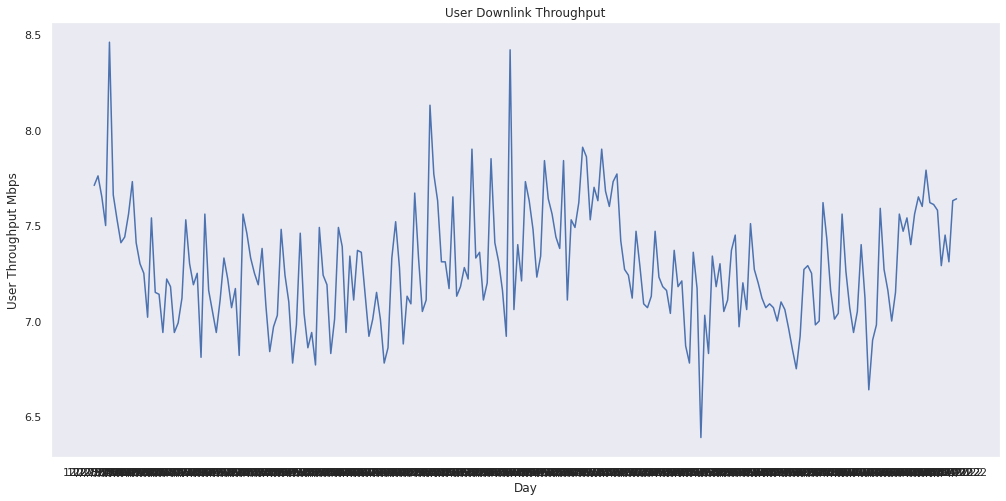

In [5]:
plt.figure(figsize=(17, 8))
plt.plot(data_Throughput['DAY'],data_Throughput['UE_DL_Throughput_Mbps'])
plt.title('User Downlink Throughput')
plt.ylabel('User Throughput Mbps')
plt.xlabel('Day')
plt.grid(True)
plt.grid(False)
plt.show()

# ARIMA
A popular and very widely used statistical method for time series forecasting and analysis is the ARIMA model. ARIMA stands for Auto-Regressive Integrated Moving Averages. The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. 

ARIMA is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

In [6]:
data_ARIMA = data_Throughput[['UE_DL_Throughput_Mbps', 'DAY']]
data_ARIMA.tail()

,UE_DL_Throughput_Mbps,DAY
222,7.29,11/8/2022
223,7.45,11/9/2022
224,7.31,11/10/2022
225,7.63,11/11/2022
226,7.64,11/14/2022


ARIMA Models are specified by three order parameters: (p, d, q),

where,

p is the order of the AR term

q is the order of the MA term

d is the number of differencing required to make the time series stationary

p is the order of the Auto Regressive (AR) term. It refers to the number of lags of Y to be used as predictors.

The value of d, is the minimum number of differencing needed to make the series stationary. If the time series is already stationary, then d = 0.

q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.


We must ensure that the time series is stationary. There are two primary way to determine whether a given time series is stationary.

What does it mean for data to be stationary?

The mean of the series should not be a function of time. The red graph below is not stationary because the mean increases over time.

**Rolling Statistics:** Plot the rolling mean and rolling standard deviation. The time series is stationary if they remain constant with time (with the naked eye look to see if the lines are straight and parallel to the x-axis).

**Augmented Dickey-Fuller Test:** dickey-fuller test can be used to check if the data is stationary or not.
The time series is considered stationary if the p-value is low (according to the null hypothesis) and the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF Statistic

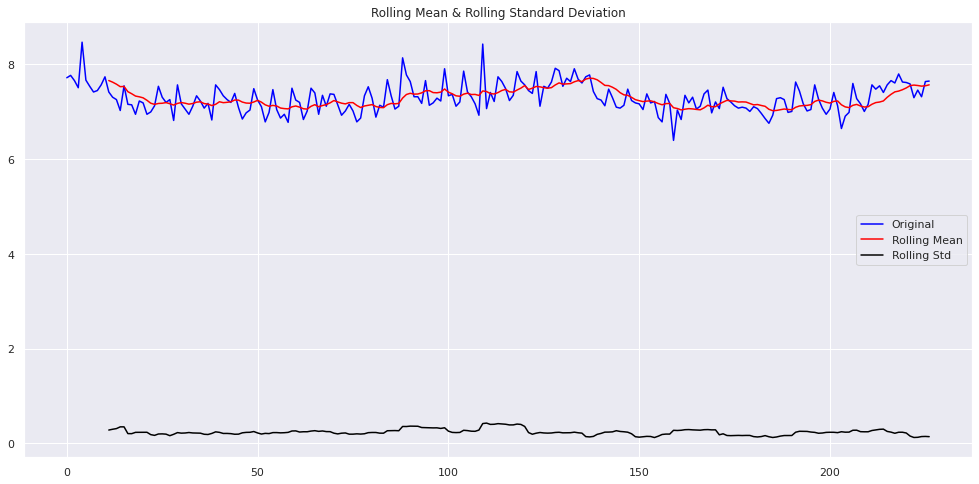

In [7]:
rolling_mean = data_ARIMA['UE_DL_Throughput_Mbps'].rolling(window = 12).mean()
rolling_std = data_ARIMA['UE_DL_Throughput_Mbps'].rolling(window = 12).std()
plt.figure(figsize=(17,8))
plt.plot(data_ARIMA['UE_DL_Throughput_Mbps'], color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

As you can see, the rolling mean and rolling standard deviation doesn't increase with time. Therefore, we can conclude that the time series is stationary.

In [8]:
result = adfuller(data_ARIMA['UE_DL_Throughput_Mbps'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Number of Lags: {}'.format(result[2]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -3.1393392465361223
p-value: 0.023775599758094037
Number of Lags: 11
Critical Values:
	1%: -3.461136478222043
	5%: -2.875078880098608
	10%: -2.5739861168199027


The ADF Statistic is close to the critical values and the p-value is less than the threshold (0.05). Thus, we can conclude that the time series is stationary.

The test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

The value of d can be taken as 0

# Train Test split. 

Out of 227 samples, 177 samples will be used for training the model and 50 samples will be used for testing the model

In [9]:
#Train Data set
train_ARIMA= data_ARIMA[:-50]
len(train_ARIMA)

177

In [10]:
#Test Data set
test_Arima = data_ARIMA[-50:]
len(test_Arima)

50

#Finding the Value of p (order of the AR term)

The PACF plot below has a large spike at lag 0, and still shows more minor but significant lags at 1, 2, 4, and 5. So we can try for ARIMA models with the p parameter being 1, 2, 3, 4, or even 5.So we’ll fit an ARIMA(2, 1, 0) model for simplicity and also try ARIMA (5,1,0) to compare.

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


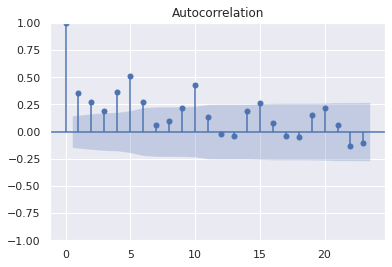

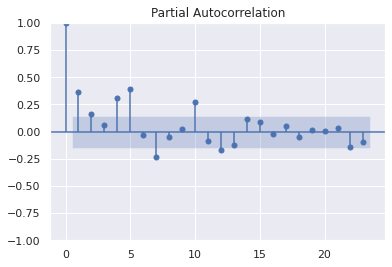

In [11]:
acf_original = plot_acf(train_ARIMA['UE_DL_Throughput_Mbps'])
pacf_original = plot_pacf(train_ARIMA['UE_DL_Throughput_Mbps'])

In [12]:
model = ARIMA(train_ARIMA['UE_DL_Throughput_Mbps'], order=(2,1,0))
model_fit = model.fit()
print(model_fit.summary())

                                 SARIMAX Results                                 
Dep. Variable:     UE_DL_Throughput_Mbps   No. Observations:                  177
Model:                    ARIMA(2, 1, 0)   Log Likelihood                 -40.105
Date:                   Thu, 08 Dec 2022   AIC                             86.211
Time:                           11:13:58   BIC                             95.722
Sample:                                0   HQIC                            90.069
                                   - 177                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5362      0.078     -6.897      0.000      -0.689      -0.384
ar.L2         -0.2387      0.083     -2.868      0.004      -0.402      -0.076
sigma2         0.0922      0

#Residuals

The residuals look random in general, and their density looks normally distributed with a mean of around 0.

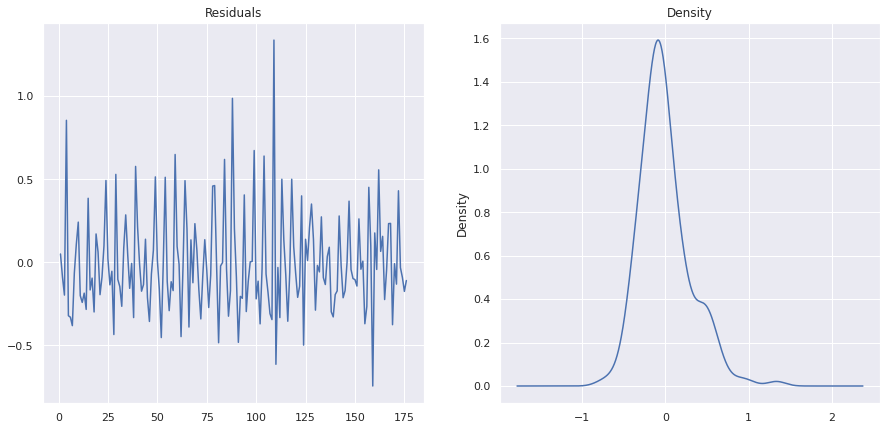

In [13]:
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2 ,figsize=(15,7))
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

# Understanding the ARIMA results above

The basic information:

***Dep. Variable – What is being predicted. In my case i am predicting UE DL Throughput

***Model – The type of model that is being used (AR, MA, ARIMA). In my case i am using ARIMA

***Date – The date when the model was run

***Time – The time the model finished

***Sample – The range of the data

***No. Observations – The number of observations

# Determine Significance
We want to make sure each term in our model is statistically significant. The null for this section is that each coefficient is NOT statistically significant. Therefore, we want each term to have a p-value of less than 0.05, so we can reject the null hypothesis with statistically significant values.
In my case each term has a p-value less than 0.005.


Rolling forecast with the ARIMA model in Python.

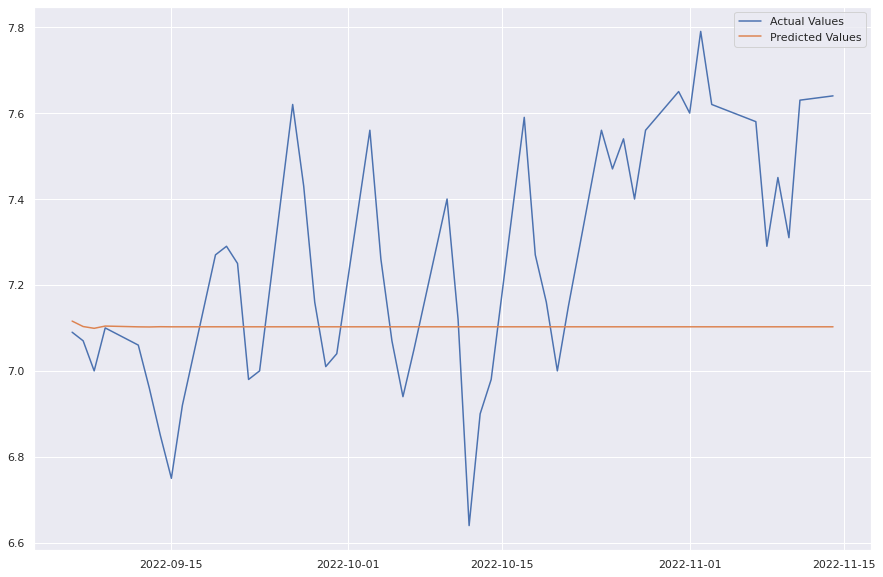

In [14]:
pred=model_fit.forecast(len(test_Arima))
plt.figure(figsize=(15, 10))
test_Dates = pd.to_datetime(test_Arima['DAY'])
plt.plot(test_Dates, test_Arima['UE_DL_Throughput_Mbps'], label = 'Actual Values')
plt.plot(test_Dates, pred,label = 'Predicted Values')
plt.legend()
plt.show()


In [15]:
test_Arima['UE_DL_Throughput_Mbps'].mean()

7.2528

# Calculating RMSE

In [16]:
from math import sqrt 
rmse=sqrt(mean_squared_error(pred,test_Arima['UE_DL_Throughput_Mbps']))
print(rmse)

0.31726272744507383


Mean Absolute Percentage Error (MAPE): MAPE is defined as the percentage of the average of absolute difference between forecasted values and true values, divided by true value.
The lower the MAPE, the better the model is.


In [17]:
mape= mean_absolute_percentage_error(test_Arima['UE_DL_Throughput_Mbps'], pred)

print('MAPE: %f' %mape)

MAPE: 0.034666


# Try ARIMA (5,1,0) Model

In [18]:
model_v1 = ARIMA(train_ARIMA['UE_DL_Throughput_Mbps'], order=(5,1,0))
model_fit_v1 = model_v1.fit()
print(model_fit_v1.summary())

                                 SARIMAX Results                                 
Dep. Variable:     UE_DL_Throughput_Mbps   No. Observations:                  177
Model:                    ARIMA(5, 1, 0)   Log Likelihood                  -3.388
Date:                   Thu, 08 Dec 2022   AIC                             18.776
Time:                           11:14:00   BIC                             37.799
Sample:                                0   HQIC                            26.492
                                   - 177                                         
Covariance Type:                     opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8348      0.080    -10.381      0.000      -0.992      -0.677
ar.L2         -0.6836      0.112     -6.107      0.000      -0.903      -0.464
ar.L3         -0.7089      0

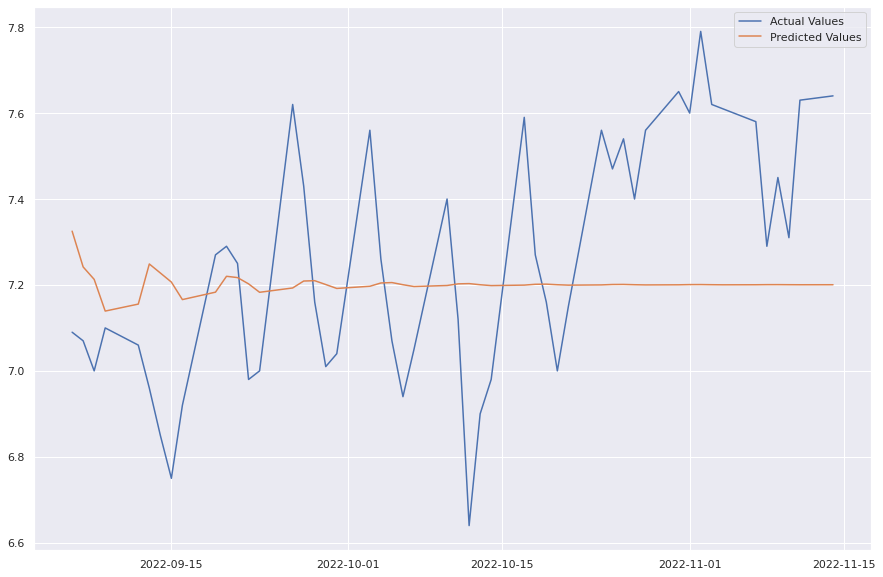

In [19]:
pred_v1=model_fit_v1.forecast(len(test_Arima))
plt.figure(figsize=(15, 10))
plt.plot(test_Dates, test_Arima['UE_DL_Throughput_Mbps'], label = 'Actual Values')
plt.plot(test_Dates, pred_v1,label = 'Predicted Values')
plt.legend()
plt.show()


#RMSE
The RMSE of ARIMA(5,1,0) is slightly better than ARIMA(2,1,0) Model

In [20]:
rmse=sqrt(mean_squared_error(pred_v1,test_Arima['UE_DL_Throughput_Mbps']))
print(rmse)

0.28685760555816986


# XGBoost-Model 2

XGBoost is short for Extreme Gradient Boosting and is an efficient implementation of the stochastic gradient boosting machine learning algorithm.Xgboost is developed on the framework of gradient boosting.

In [21]:
xgboost_v2= data_Throughput
xgboost_v2.head()

,DAY,MARKET,UE_DL_Throughput_Mbps,Peak_#_UE_In_Connected_Mode,Downlink_Data_Volume_MB_Test,PRB_Util_DL_GT_90%,PDCCH_Util_%,Weighted_Avg_PRB_Util_DL,CQI_Legacy_AllRanks
0,12/27/2021,aaaa,7.71,2476504,160315116.6,3.78,53.16,27.59,8.93
1,12/28/2021,aaaa,7.76,2486882,159726003.5,3.81,53.36,27.67,8.93
2,12/29/2021,aaaa,7.65,2513554,159701185.7,3.83,53.46,27.47,8.94
3,12/30/2021,aaaa,7.50,2586318,158817416.2,3.71,53.66,27.29,8.95
4,12/31/2021,aaaa,8.46,2405714,147716555.6,2.97,51.05,25.10,9.01


In [22]:
xgboost_v2['DAY'] = pd.to_datetime(xgboost_v2['DAY'])
xgboost_v3 = xgboost_v2[['UE_DL_Throughput_Mbps', 'DAY']]
xgboost_v3= xgboost_v3.set_index('DAY')
xgboost_v3.head()

,UE_DL_Throughput_Mbps
DAY,
2021-12-27,7.71
2021-12-28,7.76
2021-12-29,7.65
2021-12-30,7.50
2021-12-31,8.46


<AxesSubplot:xlabel='DAY'>

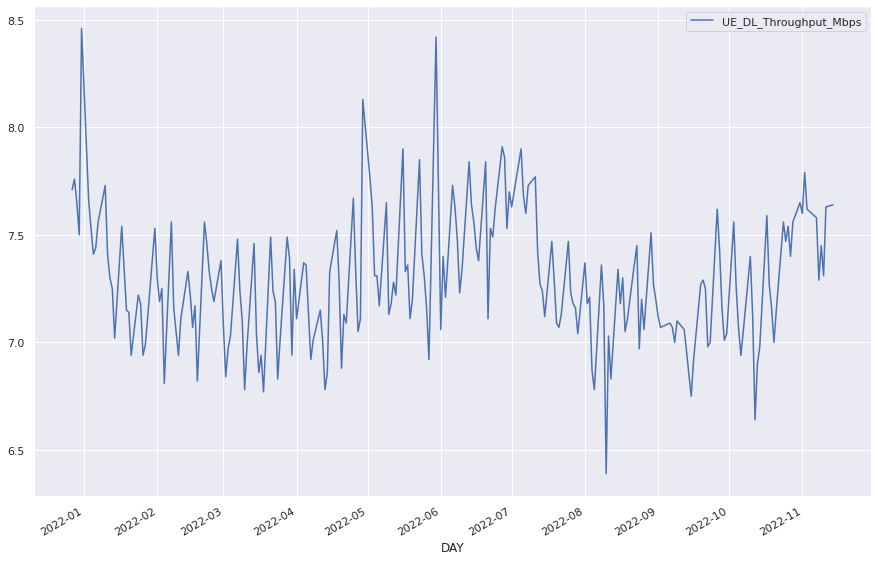

In [23]:
xgboost_v3.plot(figsize=(15, 10))

#Train Test Split

In [24]:
#Train and Test Data set
train_xgboost_v3= xgboost_v3[:-50]
test_xgboost_v3 = xgboost_v3[-50:]

#Plot the Train and Test Data set together.

<AxesSubplot:title={'center':'UE_DL_Throughput_Mbps'}, xlabel='DAY'>

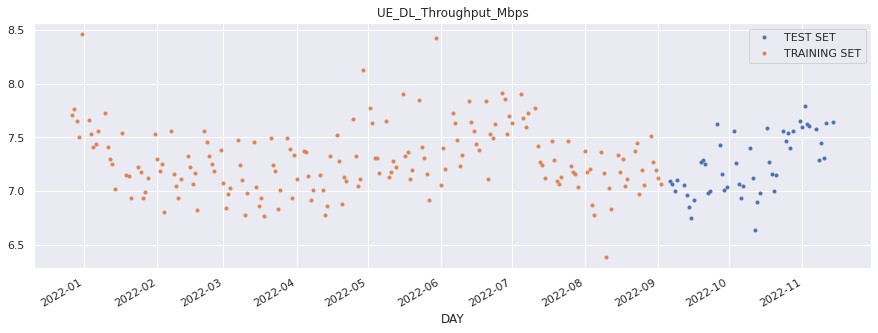

In [25]:
 test_xgboost_v3 \
    .rename(columns={'UE_DL_Throughput_Mbps': 'TEST SET'}) \
    .join(train_xgboost_v3.rename(columns={'UE_DL_Throughput_Mbps': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='UE_DL_Throughput_Mbps', style='.')

Create time-series features from our data.

XGBoost is a process of supervised learning to work with it we are required to make our data the data for supervised learning.

In [26]:
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [27]:
X_train, y_train = create_features(train_xgboost_v3, label='UE_DL_Throughput_Mbps')
X_test, y_test = create_features(test_xgboost_v3, label='UE_DL_Throughput_Mbps')
X_train

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
DAY,,,,,,,,
2021-12-27,0,0,4,12,2021,361,27,52
2021-12-28,0,1,4,12,2021,362,28,52
2021-12-29,0,2,4,12,2021,363,29,52
2021-12-30,0,3,4,12,2021,364,30,52
2021-12-31,0,4,4,12,2021,365,31,52
...,...,...,...,...,...,...,...,...
2022-08-29,0,0,3,8,2022,241,29,35
2022-08-30,0,1,3,8,2022,242,30,35
2022-08-31,0,2,3,8,2022,243,31,35


Fitting our data into the model.

In [28]:
reg = xgb.XGBRegressor(n_estimators=1000)

reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False)


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:797: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  UserWarning,


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=1000,
             n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=0, reg_lambda=1, ...)

In [29]:
test_xgboost_v3['UE_DL_Throughput_Mbps_Predicted'] = reg.predict(X_test)
data_all = pd.concat([test_xgboost_v3, train_xgboost_v3], sort=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='DAY'>

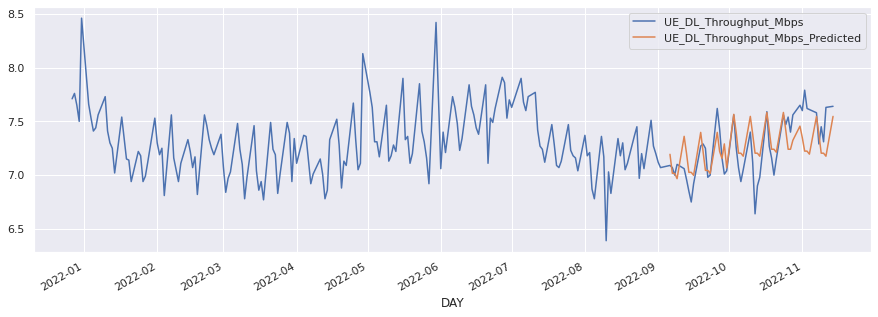

In [30]:
data_all[['UE_DL_Throughput_Mbps','UE_DL_Throughput_Mbps_Predicted']].plot(figsize=(15, 5))

#RMSE

In [31]:
rmse=sqrt(mean_squared_error(test_xgboost_v3['UE_DL_Throughput_Mbps_Predicted'],test_xgboost_v3['UE_DL_Throughput_Mbps']))
print(rmse)

0.22398439419934787


# LSTM Model 3

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies

https://medium.com/analytics-vidhya/3-time-series-forecasting-using-lstm-e14b93f4ec7c

In [32]:
data_lstm = pd.read_csv("/kaggle/input/lstmdata/xgboost_data.csv")
data_lstm.tail()

,DAY,MARKET,UE_DL_Throughput_Mbps,Peak_#_UE_In_Connected_Mode,Downlink_Data_Volume_MB_Test,PRB_Util_DL_GT_90%,PDCCH_Util_%,Weighted_Avg_PRB_Util_DL,CQI_Legacy_AllRanks
222,11/8/2022,aaaa,7.29,3077295,189724790.3,4.71,53.77,29.35,8.88
223,11/9/2022,aaaa,7.45,3139004,188569430.9,4.51,54.10,29.15,8.89
224,11/10/2022,aaaa,7.31,3183115,190635289.2,4.74,53.84,29.90,8.88
225,11/11/2022,aaaa,7.63,3039370,187259700.8,4.21,53.60,28.62,8.93
226,11/14/2022,aaaa,7.64,3062200,182978593.6,3.99,53.19,28.07,8.93


In [33]:
data_lstm_df1=data_lstm[['UE_DL_Throughput_Mbps', 'DAY']]
data_lstm_df1.head()

,UE_DL_Throughput_Mbps,DAY
0,7.71,12/27/2021
1,7.76,12/28/2021
2,7.65,12/29/2021
3,7.50,12/30/2021
4,8.46,12/31/2021


Train Test Split

In [34]:
train_lstm= data_lstm_df1[:-50]
test_lstm = data_lstm_df1[-50:]

In [35]:
train_dates = pd.to_datetime(train_lstm['DAY'])
test_dates  = pd.to_datetime(test_lstm['DAY'])

# Prepare Data

Scaling of the data helps in reducing the training time for neural network models.

With the value of 50 that I have given, the model will work in such a way that it examines 50 data and predicts the next one, then examines 50 data again and tries to predict the next one.

In [36]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(train_lstm['UE_DL_Throughput_Mbps'].values.reshape(-1,1))

prediction_days = 50

lstm_x_train = []
lstm_y_train = []

for x in range(prediction_days, len(scaled_data)):
    lstm_x_train.append(scaled_data[x-prediction_days:x, 0])
    lstm_y_train.append(scaled_data[x, 0])


lstm_x_train, lstm_y_train = np.array(lstm_x_train), np.array(lstm_y_train)
lstm_x_train = np.reshape(lstm_x_train, (lstm_x_train.shape[0], lstm_x_train.shape[1], 1))

I will use a Sequential model. The activation function used is relu and the dropout function will be used to increase the efficiency.
The dense layer will return a single value that will the UE DL Throughput predicted.

In [37]:
model = Sequential()

model.add(LSTM(units =256, activation='relu', return_sequences=True, input_shape = (lstm_x_train.shape[1],1)))
model.add(Dropout(0.1))
model.add(LSTM(units =256, activation='relu', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(units =256, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(units=1)) # Prediction of the next value

2022-12-08 11:14:04.801412: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [38]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

history = model.fit(lstm_x_train, lstm_y_train, epochs = 25, batch_size=32, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50, 256)           264192    
_________________________________________________________________
dropout (Dropout)            (None, 50, 256)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 256)           525312    
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

2022-12-08 11:14:05.569251: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


4/4 [==============================] - 7s 594ms/step - loss: 0.1606 - val_loss: 0.0134
Epoch 2/25
4/4 [==============================] - 1s 373ms/step - loss: 0.0286 - val_loss: 0.0111
Epoch 3/25
4/4 [==============================] - 1s 366ms/step - loss: 0.0246 - val_loss: 0.0078
Epoch 4/25
4/4 [==============================] - 1s 362ms/step - loss: 0.0247 - val_loss: 0.0066
Epoch 5/25
4/4 [==============================] - 2s 358ms/step - loss: 0.0235 - val_loss: 0.0061
Epoch 6/25
4/4 [==============================] - 1s 356ms/step - loss: 0.0218 - val_loss: 0.0061
Epoch 7/25
4/4 [==============================] - 1s 361ms/step - loss: 0.0216 - val_loss: 0.0061
Epoch 8/25
4/4 [==============================] - 1s 368ms/step - loss: 0.0226 - val_loss: 0.0061
Epoch 9/25
4/4 [==============================] - 1s 361ms/step - loss: 0.0227 - val_loss: 0.0062
Epoch 10/25
4/4 [==============================] - 1s 360ms/step - loss: 0.0231 - val_loss: 0.0061
Epoch 11/25
4/4 [=============

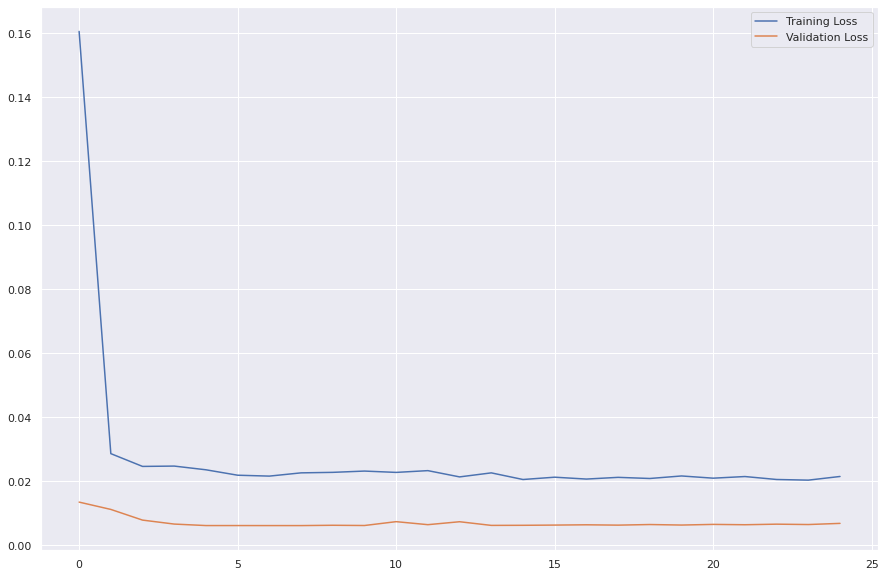

In [39]:
plt.figure(figsize=(15, 10))
plt.plot(history.history['loss'], label = 'Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.show()

I will perform a predict operation on our model. The estimated values will be normalized with the inverse_transform operation in order to compare these predicted values with the actual values we have.

In [40]:
actual_thrp = test_lstm['UE_DL_Throughput_Mbps'].values
total_thrp = pd.concat((train_lstm['UE_DL_Throughput_Mbps'], test_lstm['UE_DL_Throughput_Mbps']),axis=0)

model_inputs = total_thrp[len(total_thrp)-len(test_lstm)-prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)


# Make Predictions on Test Data
lstm_x_test = []

for x in range(prediction_days, len(model_inputs)):
    lstm_x_test.append(model_inputs[x-prediction_days:x, 0])

lstm_x_test = np.array(lstm_x_test)
lstm_x_test = np.reshape(lstm_x_test, (lstm_x_test.shape[0], lstm_x_test.shape[1], 1))

pred = model.predict(lstm_x_test)
pred = scaler.inverse_transform(pred)

MAE is the Mean of Absolute value of Errors

In [41]:
mae= mean_absolute_error(test_lstm['UE_DL_Throughput_Mbps'],pred)
mae

0.22139452476501462

Below plot is for the predecited UE DL Throughput values vs actual Test data set UE DL THroughput values. The predicted throughput values is within error range of ~ 0.23 from the actual throughput values.

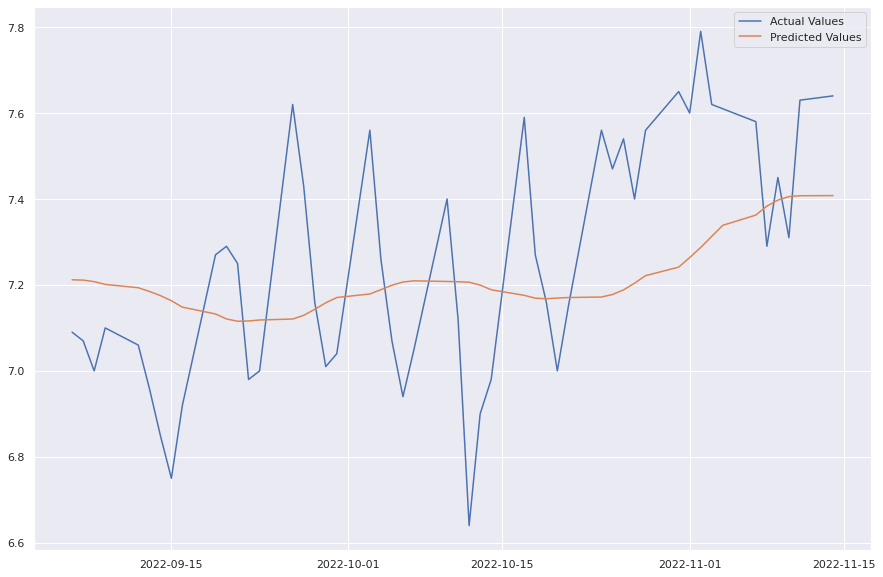

In [42]:
### Visualization ###
#####################
pred_ = pd.DataFrame(test_lstm['DAY'])
pred_['UE_DL_Throughput_Mbps'] = pred
pred_['DAY'] = pd.to_datetime(pred_['DAY'])
plt.figure(figsize=(15, 10))
plt.plot(test_dates, test_lstm['UE_DL_Throughput_Mbps'], label = 'Actual Values')
plt.plot(pred_['DAY'], pred_['UE_DL_Throughput_Mbps'],label = 'Predicted Values' )
plt.legend()
plt.show()

RMSE is the Root of the Mean of the Square of Errors

The RMSE for LSTM model is 0.26

In [43]:
rmse=sqrt(mean_squared_error(pred_['UE_DL_Throughput_Mbps'],test_lstm['UE_DL_Throughput_Mbps']))
print(rmse)

0.25768981419787096


# Conclusion

For this project, I used Time Series Forecasting to predict UE_DL_Throughput in Mbps. I used ARIMA , XGBoost and LSTM models to predict the Downlink UE Throughput. 
For ARIMA, i used ARIMA(2,1,0) and ARIMA(5,1,0) and RMSE observed was 0.317 and 0.287 respectively. The RMSE observed was slightly better for ARIMA(5,1,0)

Using XGBoost, the RMSE observed was 0.224 which was better than ARIMA models.

With LSTM, the RMSE seen was 0.263 which was slightly worse than XGBoost but better than ARIMA models.

In terms of model performance, XGBoost seems to have given the best result followed by LSTM.

In future, impact of other KPIs will be considered as well to predict the Downlink User throughput and compared against the performance seen in this project.